<a href="https://colab.research.google.com/github/alastra32/DS-Unit-2-Applied-Modeling/blob/master/module3/assignment_applied_modeling_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Applied Modeling, Module 3

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploration, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Share at least 1 visualization on Slack.

(If you have not yet completed an initial model yet for your portfolio project, then do today's assignment using your Tanzania Waterpumps model.)

## Stretch Goals
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox.I Get readable category names on your plot, instead of integer category codes.

## Links
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

## Setup 

In [1]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly

     |████████████████████████████████| 102kB 8.6MB/s 
     |████████████████████████████████| 133kB 32.6MB/s 
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.1.1)
     |████████████████████████████████| 614kB 50.2MB/s 
     |████████████████████████████████| 235kB 50.1MB/s 
     |████████████████████████████████| 307kB 53.8MB/s 
     |████████████████████████████████| 215kB 54.2MB/s 
     |████████████████████████████████| 51kB 25.2MB/s 
     |████████████████████████████████| 51kB 24.0MB/s 
     |████████████████████████████████| 737kB 64.1MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.3.0-py2.py3-none-any.whl size=145035 sha256=dda8ab70a6ec196a7d7e2c095c11c9a15790d8911e076dd65e6083adf69b6886
  Stored in directory: /root/.cache/pip/wheels/ce/c7/f1/dbfef4848ebb048cb1d4a22d1ed0c62d8ff2523747235e19fe
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27084 sha256=62ba52f738a0504ea497ad53c1790dcd4dc08f1

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split

# merge train_features.csv & train_labels.csv
trainandval = pd.merge(pd.read_csv('https://raw.githubusercontent.com/alastra32/DS-Unit-2-Kaggle-Challenge/master/data/tanzania/train_features.csv'), 
                 pd.read_csv('https://raw.githubusercontent.com/alastra32/DS-Unit-2-Kaggle-Challenge/master/data/tanzania/train_labels.csv'))

# read test_features.csv & sample_submission.csv
test = pd.read_csv('https://raw.githubusercontent.com/alastra32/DS-Unit-2-Kaggle-Challenge/master/data/tanzania/test_features.csv')
sample_submission = pd.read_csv('https://raw.githubusercontent.com/alastra32/DS-Unit-2-Kaggle-Challenge/master/data/tanzania/sample_submission.csv')

In [0]:
# import block
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('dark_background')
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
import category_encoders as ce
from xgboost import XGBClassifier

In [4]:
# train validation split
train, val = train_test_split(trainandval, train_size=0.95, test_size=0.05, 
                              stratify=trainandval['status_group'], random_state=42)

train.shape, val.shape, test.shape

((56430, 41), (2970, 41), (14358, 40))

## Manual Mode 



In [0]:
# We need a function that returns the mode of a given series for the imputer function.
def manual_mode(feature):
  try: 
    return feature.mode()[0]
  except:
    pass

## Imputer

In [0]:
# imputes by the lowest non-null region measure


def fill_nulls(df, feature, method):
  #attempt to fill nulls by method in succesively larger geographic scopes
  df = df.copy()# avoid settingwithcopy warning
  geo_scopes = ['ward', 'lga', 'region', 'basin']
  
  if method == 'mode':
    method = manual_mode
  
  for scope in geo_scopes:
    if df[feature].isnull().sum() == 0:
      break
    df[feature] = df[feature].fillna(df.groupby(scope)[feature].transform(method))

  return df[feature]


def impute(df, features, method):
  #imputation of given features by given method (mean/median/mode)
  df = df.copy()
  
  for feature in features:
    df[feature] = fill_nulls(df, feature, method)

  return df

## Wrangler

In [0]:


def flag_missing_values(df):
  '''add "<FEATURE>_MISSING" flag feature for all columns with nulls'''
  df.copy()
  
  columns_with_nulls = df.columns[df.isna().any()]
  
  for col in columns_with_nulls:
    df[col+'_MISSING'] = df[col].isna()
  
  return df


def convert_dummy_nulls(df):
  '''Convert 0 to NaN's'''
  df = df.copy()
  
  # replace near-zero latitudes with zero
  df['latitude'] = df['latitude'].replace(-2e-08, 0)
  
  zero_columns = ['longitude', 'latitude', 'construction_year', 'gps_height', 
                  'population']
  
  for col in zero_columns:
    df[col] = df[col].replace(0, np.nan)
    
  return df
  
    
def clean_text_columns(df):
  '''convert text to lowercase, remove non-alphanumerics, unknowns to NaN'''
  df = df.copy()
  
  text_columns = df[df.columns[(df.applymap(type) == str).all(0)]]
  unknowns = ['unknown', 'notknown', 'none', 'nan', '']
    
  for col in text_columns:
    df[col] = df[col].str.lower().str.replace('\W', '')
    df[col] = df[col].replace(unknowns, np.nan)

  return df


def get_distances_to_population_centers(df):
  '''create a distance feature for population centers'''
  df = df.copy()
  population_centers = {'dar': (6.7924, 39.2083), 
                        'mwanza': (2.5164, 32.9175),
                        'dodoma': (6.1630, 35.7516)}
  
  for city, loc in population_centers.items():
    df[city+'_distance'] = ((((df['latitude']-loc[0])**2)
                           + ((df['longitude']-loc[1])**2))**0.5)
  
  return df


def engineer_date_features(df):
  df = df.copy()
  
  # change date_recorded to datetime format
  df['date_recorded'] = pd.to_datetime(df.date_recorded, 
                                      infer_datetime_format=True)
    
  # extract components from date_recorded
  df['year_recorded'] = df['date_recorded'].dt.year
  df['month_recorded'] = df['date_recorded'].dt.month
  df['day_recorded'] = df['date_recorded'].dt.day

  df['inspection_interval'] = df['year_recorded'] - df['construction_year']
  
  return df


def wrangle(df):
    '''cleaning/engineering function'''
    df = df.copy()
    
    df = convert_dummy_nulls(df)   
    df = clean_text_columns(df)
    df = get_distances_to_population_centers(df)
    df = engineer_date_features(df)
    df = flag_missing_values(df)
    
    drop_features = ['recorded_by', 'id', 'date_recorded']
    df = df.drop(columns=drop_features)

    # Apply imputation
    numeric_columns = df.select_dtypes(include = 'number').columns
    nonnumeric_columns = df.select_dtypes(exclude = 'number').columns
    
    df = impute(df, numeric_columns, 'median')
    df = impute(df, nonnumeric_columns, 'mode')

    return df

## Engineer, Pipe, and Train

In [0]:
# clean and engineer all datasets 
train_wrangled = wrangle(train)
val_wrangled = wrangle(val)
test_wrangled = wrangle(test)

In [0]:
# arrange data into X features matrix and y target vector
target = 'status_group'

X_train = train_wrangled.drop(columns=target)
y_train = train_wrangled[target]

X_val = val_wrangled.drop(columns=target)
y_val = val_wrangled[target]

X_test = test_wrangled

In [46]:

# Use Ordinal Encoder, outside of a pipeline
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded= encoder.fit_transform(X_val)
model = RandomForestClassifier(n_estimators=129, max_depth=29, min_samples_leaf=2, 
                            random_state=42, min_impurity_decrease=2.22037e-16, n_jobs=-1)
model.fit(X_train_encoded, y_train)



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=29, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=2.22037e-16,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=129, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [47]:
#score
model.score(X_val_encoded,y_val)

0.8111111111111111

In [24]:
!pip install pdpbox

     |████████████████████████████████| 57.7MB 1.3MB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690723 sha256=7555e7b2f7c495b85282a85a9a28c010298ab6f7f8567162fb102e965df444ef
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


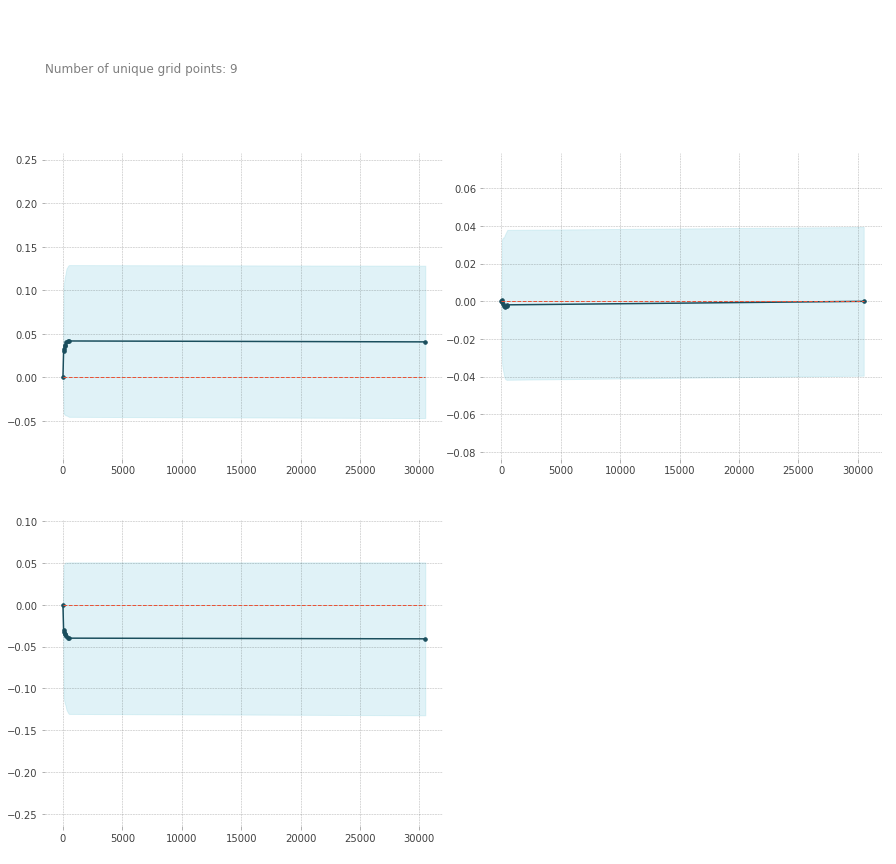

In [53]:
# Use Pdpbox
%matplotlib inline
import matplotlib.pyplot as plt
from pdpbox import pdp
from pdpbox import pdp

#features = ['quantity_group', 'waterpoint_type_group']
features=X_train_encoded.columns
feature = 'population'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_train_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

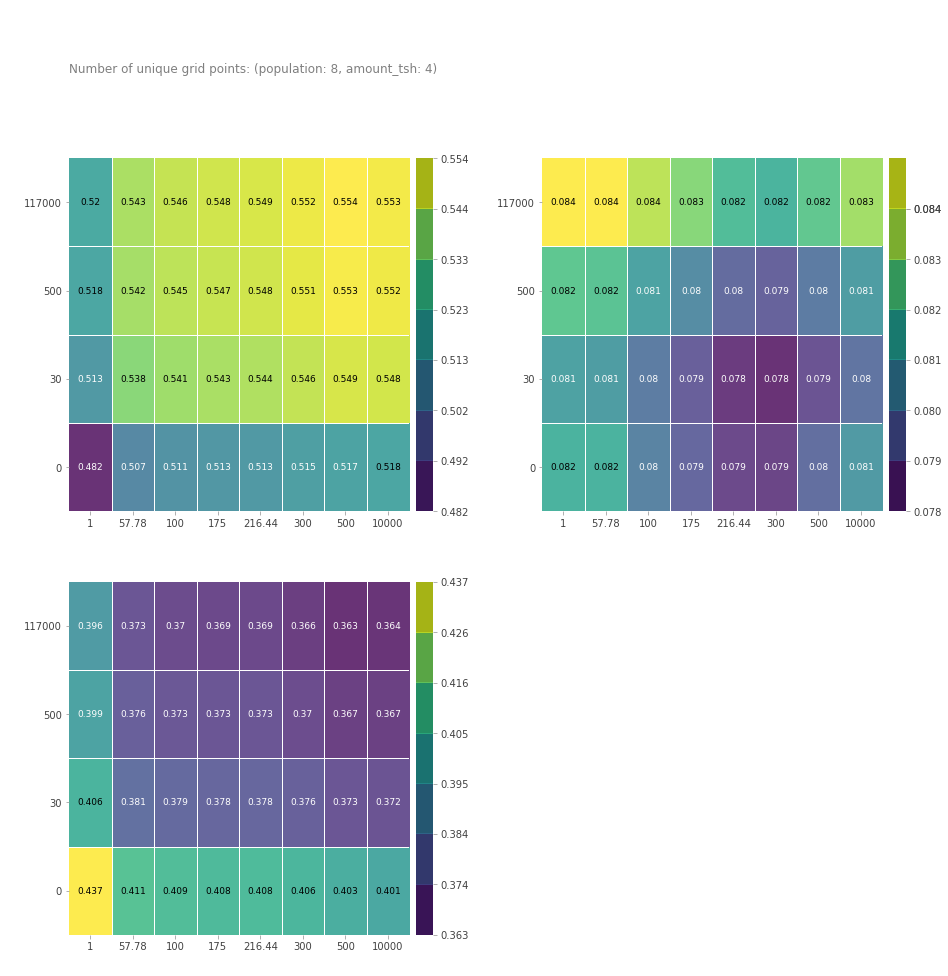

In [54]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['population', 'amount_tsh']

interaction = pdp_interact(
  model=model,
  dataset=X_val_encoded,
  model_features=X_val_encoded.columns,
  features=features 
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);